In [11]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, r2_score
import warnings
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

In [12]:

# --- 1. Advanced Feature Engineering ---
# (Your feature engineering functions remain the same, they are well-written)

def weighted_average_price(df):
    """Calculates the Weighted Average Price (WAP)."""
    wap = (df['bid_price1'] * df['ask_volume1'] + df['ask_price1'] * df['bid_volume1']) / (df['bid_volume1'] + df['ask_volume1'])
    return wap

def log_return(series):
    """Calculates the log return of a series."""
    return np.log(series).diff()

def realized_volatility(series):
    """Calculates the realized volatility."""
    return np.sqrt(np.sum(series**2))

def count_unique(series):
    """Counts unique values in a series."""
    return len(np.unique(series))

def calculate_book_imbalance(df):
    """Calculates the order book imbalance."""
    # Ensure columns exist before calculation
    if 'bid_volume1' in df.columns and 'bid_volume2' in df.columns and \
       'ask_volume1' in df.columns and 'ask_volume2' in df.columns:
        bid_vol_sum = df['bid_volume1'] + df['bid_volume2']
        ask_vol_sum = df['ask_volume1'] + df['ask_volume2']
        imbalance = (bid_vol_sum - ask_vol_sum) / (bid_vol_sum + ask_vol_sum)
        return imbalance
    return 0 # Return neutral imbalance if columns are missing

def calculate_spread(df):
    """Calculates the bid-ask spread."""
    if 'ask_price1' in df.columns and 'bid_price1' in df.columns:
        spread = (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1']) / 2)
        return spread
    return 0 # Return zero spread if columns are missing

def create_features_vectorized(df):
    """Creates features from the combined book and ohlcv data using vectorized operations."""
    # WAP and Log Returns
    df['wap'] = weighted_average_price(df)
    # --- OPTIMIZATION: Calculate log returns within each asset group ---
    df['log_return_wap'] = df.groupby('asset')['wap'].transform(log_return)

    # Realized Volatility over different time windows
    windows = [10, 60, 300] # 10-sec, 1-min, 5-min
    for window in windows:
        # --- OPTIMIZATION: Use groupby().rolling() which is much faster than apply() ---
        df[f'realized_vol_{window}s'] = df.groupby('asset')['log_return_wap'].rolling(window=window, min_periods=1).apply(realized_volatility, raw=True).reset_index(level=0, drop=True)

    # Book Imbalance and Spread
    df['book_imbalance'] = calculate_book_imbalance(df)
    df['spread'] = calculate_spread(df)

    # Rolling window features for key metrics
    metrics = ['log_return_wap', 'book_imbalance', 'spread']
    for metric in metrics:
        for window in windows:
            # --- OPTIMIZATION: Use groupby().rolling().mean/std ---
            df[f'{metric}_mean_{window}s'] = df.groupby('asset')[metric].rolling(window=window, min_periods=1).mean().reset_index(level=0, drop=True)
            df[f'{metric}_std_{window}s'] = df.groupby('asset')[metric].rolling(window=window, min_periods=1).std().reset_index(level=0, drop=True)

    # Time-based features
    df['seconds_in_bucket'] = df.index.second
    
    return df


In [13]:
# --- 2. Data Loading and Processing (OPTIMIZED & FIXED) ---

def load_and_prepare_data_csv(files, data_type='train'):
    """Loads, preprocesses, and engineers features from multiple asset CSV files."""
    data = []
    
    for file_path in files:
        print(f"Processing {data_type} file: {file_path}")
        df = pd.read_csv(file_path)
        
        # Standardize column names: strip whitespace and convert to lowercase.
        df.columns = df.columns.str.strip().str.lower()

        df.dropna(subset=['bid_price1', 'ask_price1', 'bid_volume1', 'ask_volume1'], inplace=True)
        if df.empty:
            print(f"Warning: File {file_path} is empty after cleaning. Skipping.")
            continue

        asset_name = os.path.basename(file_path).split('.')[0]
        df['asset'] = asset_name
        
        if pd.api.types.is_string_dtype(df['timestamp']):
             df['timestamp'] = pd.to_datetime(df['timestamp'], dayfirst=True)
        else:
             df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

        data.append(df)
        
    if not data:
        return pd.DataFrame()

    full_df = pd.concat(data).sort_values(by=['asset', 'timestamp']).set_index('timestamp')
    
    print("Applying feature engineering (vectorized)...")
    full_df = create_features_vectorized(full_df)
    
    # Reset index to make 'asset' and 'timestamp' regular columns before filling
    full_df.reset_index(inplace=True)

    print("Filling NaNs...")
    # Explicitly select only the numeric/feature columns to fill,
    # leaving 'asset' and 'timestamp' untouched.
    cols_to_fill = full_df.columns.drop(['asset', 'timestamp'])
    full_df[cols_to_fill] = full_df.groupby('asset')[cols_to_fill].ffill().bfill()

    # Set the timestamp index for the final returned dataframe
    full_df.set_index('timestamp', inplace=True)

    return full_df


print("Looking for train and test files in Kaggle directory...")
train_path = '/kaggle/input/gq-implied-volatility-forecasting/train/*.csv'
test_path = '/kaggle/input/gq-implied-volatility-forecasting/test/*.csv'

train_files = glob.glob(train_path)
test_files = glob.glob(test_path)

train_files = sorted(list(set(train_files)))
test_files = sorted(list(set(test_files)))

print(f"Found {len(train_files)} training files: {train_files}")
print(f"Found {len(test_files)} testing files: {test_files}")

full_train_df = load_and_prepare_data_csv(train_files, data_type='train')

# Display head of the dataframe
print("\nDisplaying the head of the processed training data:")
print(full_train_df.head())


if not full_train_df.empty:
    if 'label' not in full_train_df.columns:
        print("\n--- FATAL ERROR ---")
        print("The target column 'label' was not found in your training data.")
        print("The model cannot be trained without this target variable.")
        print("\nPlease check your .Train.csv files to ensure this column exists.")
        print("\nAvailable columns are:")
        print(list(full_train_df.columns))
        full_train_df = pd.DataFrame() # Empty the dataframe to stop further processing
    else:
        full_train_df.reset_index(inplace=True)
        
        full_train_df['labels'] = full_train_df.groupby('asset')['label'].shift(-10)
        full_train_df.dropna(inplace=True)
        
        # Restore the timestamp index for time series operations
        full_train_df.set_index('timestamp', inplace=True)

        print("\nData loading and feature engineering complete.")
        print("Shape of the final training data:", full_train_df.shape)
else:
    print("Training data is empty. Please check the file paths.")

Looking for train and test files in Kaggle directory...
Found 7 training files: ['/kaggle/input/gq-implied-volatility-forecasting/train/BTC.csv', '/kaggle/input/gq-implied-volatility-forecasting/train/DOGE.csv', '/kaggle/input/gq-implied-volatility-forecasting/train/DOT.csv', '/kaggle/input/gq-implied-volatility-forecasting/train/ETH.csv', '/kaggle/input/gq-implied-volatility-forecasting/train/LINK.csv', '/kaggle/input/gq-implied-volatility-forecasting/train/SHIB.csv', '/kaggle/input/gq-implied-volatility-forecasting/train/SOL.csv']
Found 7 testing files: ['/kaggle/input/gq-implied-volatility-forecasting/test/BTC.csv', '/kaggle/input/gq-implied-volatility-forecasting/test/DOGE.csv', '/kaggle/input/gq-implied-volatility-forecasting/test/DOT.csv', '/kaggle/input/gq-implied-volatility-forecasting/test/ETH.csv', '/kaggle/input/gq-implied-volatility-forecasting/test/LINK.csv', '/kaggle/input/gq-implied-volatility-forecasting/test/SHIB.csv', '/kaggle/input/gq-implied-volatility-forecasting/t

In [14]:
# --- 3. Model Training with Time Series Cross-Validation ---

if not full_train_df.empty:
    features = [col for col in full_train_df.columns if col not in ['label', 'labels', 'asset', 'asset_cat']]
    
    # The 'asset' column needs to be handled separately if it's not already numeric
    # For LightGBM, we can convert it to a category type
    full_train_df['asset_cat'] = full_train_df['asset'].astype('category').cat.codes
    features.append('asset_cat')
    
    X = full_train_df[features]
    y = full_train_df['labels']

    # Define more flexible model parameters
    lgbm_params = {
        'objective': 'regression_l1',
        'n_estimators': 1000,
        'learning_rate': 0.05,
        'num_leaves': 64, # Increased from default 31
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': 42,
        'n_jobs': -1
    }

    model = lgb.LGBMRegressor(**lgbm_params)
    
    def pearson_corr(y_true, y_pred):
        # Handle cases where predictions or true values are constant
        if np.std(y_pred) < 1e-6 or np.std(y_true) < 1e-6:
            return 0.0
        return pd.Series(y_true).corr(pd.Series(y_pred))

    n_splits = 5
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    print(f"\nStarting Time Series Cross-Validation with {n_splits} splits...")
    
    oof_preds = np.zeros(len(X))
    oof_indices = []
    
    for fold, (train_index, val_index) in enumerate(tscv.split(X)):
        print(f"--- Fold {fold+1}/{n_splits} ---")
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        model.fit(X_train, y_train,
                  eval_set=[(X_val, y_val)],
                  eval_metric='l1',
                  callbacks=[lgb.early_stopping(100, verbose=False)],
                  categorical_feature=['asset_cat'])
        
        val_preds = model.predict(X_val)
        oof_preds[val_index] = val_preds
        oof_indices.extend(val_index)
        
        score = pearson_corr(y_val, val_preds)
        print(f"Fold {fold+1} Pearson Correlation: {score:.4f}")

    overall_oof_score = pearson_corr(y.iloc[oof_indices], oof_preds[oof_indices])
    print(f"\nOverall Out-of-Fold Pearson Correlation: {overall_oof_score:.4f}")



Starting Time Series Cross-Validation with 5 splits...
--- Fold 1/5 ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11730
[LightGBM] [Info] Number of data points in the train set: 397299, number of used features: 46
[LightGBM] [Info] Start training from score 0.000060
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with po


Training final model on all available data...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.699249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11795
[LightGBM] [Info] Number of data points in the train set: 2383774, number of used features: 48
[LightGBM] [Info] Start training from score 0.000060
Final model training complete.

--- Feature Importance Analysis ---
Top 20 Most Important Features:
                     feature  importance
38  book_imbalance_mean_300s        3655
39   book_imbalance_std_300s        3503
32  log_return_wap_mean_300s        3332
45           spread_std_300s        3312
25         realized_vol_300s        3285
37    book_imbalance_std_60s        2848
30   log_return_wap_mean_60s        2765
24          realized_vol_60s        2696
36   book_imbalance_mean_60s        2530
43            spread_std_60s        2362
46         seconds_in_bucket        2355
31    log_return

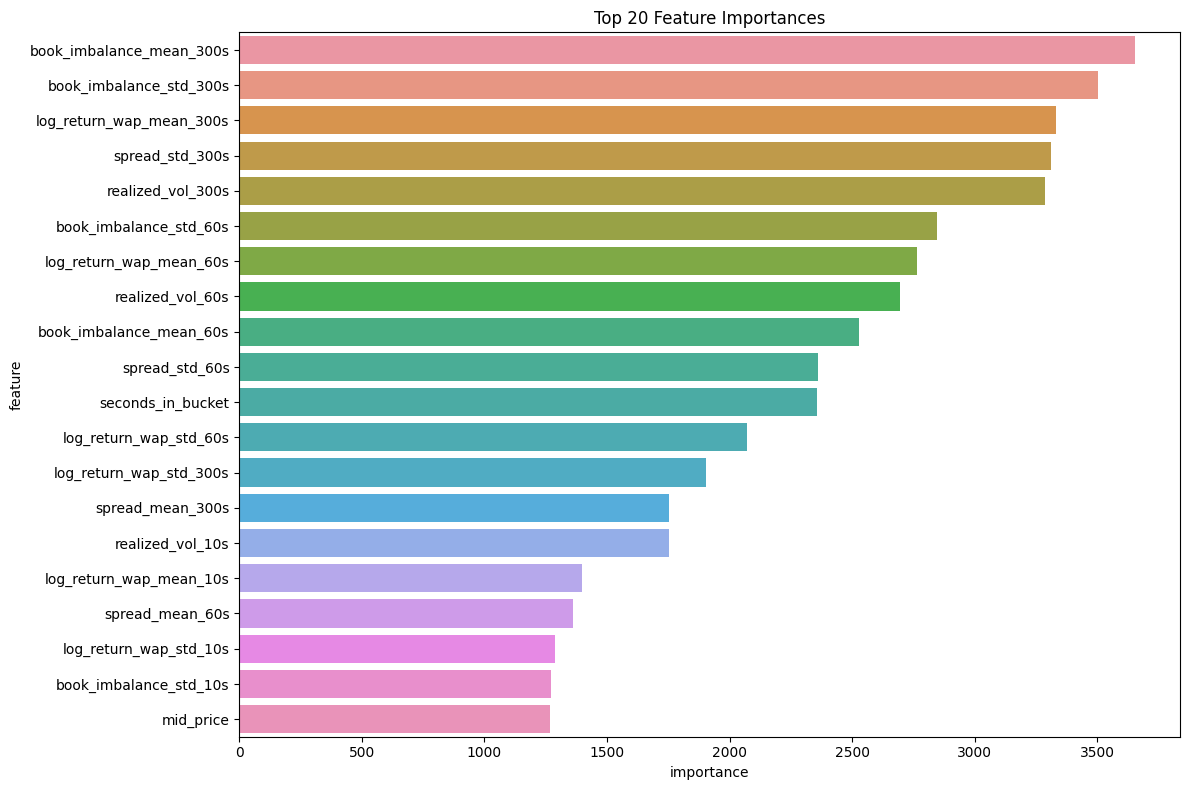

In [15]:

    # --- 4. Final Model Training ---
    print("\nTraining final model on all available data...")
    final_model = lgb.LGBMRegressor(**lgbm_params)
    final_model.fit(X, y, categorical_feature=['asset_cat'])
    print("Final model training complete.")

    # --- BONUS: Feature Importance Analysis ---
    print("\n--- Feature Importance Analysis ---")
    
    # Create a dataframe of feature importances
    importance_df = pd.DataFrame({
        'feature': features,
        'importance': final_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("Top 20 Most Important Features:")
    print(importance_df.head(20))
    
    # Plot the feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=importance_df.head(20))
    plt.title('Top 20 Feature Importances')
    plt.tight_layout()
    plt.show()



Generating predictions on the test set...
Processing test file: /kaggle/input/gq-implied-volatility-forecasting/test/BTC.csv
Processing test file: /kaggle/input/gq-implied-volatility-forecasting/test/DOGE.csv
Processing test file: /kaggle/input/gq-implied-volatility-forecasting/test/DOT.csv
Processing test file: /kaggle/input/gq-implied-volatility-forecasting/test/ETH.csv
Processing test file: /kaggle/input/gq-implied-volatility-forecasting/test/LINK.csv
Processing test file: /kaggle/input/gq-implied-volatility-forecasting/test/SHIB.csv
Processing test file: /kaggle/input/gq-implied-volatility-forecasting/test/SOL.csv
Applying feature engineering (vectorized)...
Filling NaNs...

Submission file created successfully!
            timestamp    labels
0 1970-01-01 00:00:01  0.000060
1 1970-01-01 00:00:01  0.000069
2 1970-01-01 00:00:01  0.000059
3 1970-01-01 00:00:01  0.000075
4 1970-01-01 00:00:01  0.000057

Plotting a sample of Out-of-Fold predictions vs Actual values...


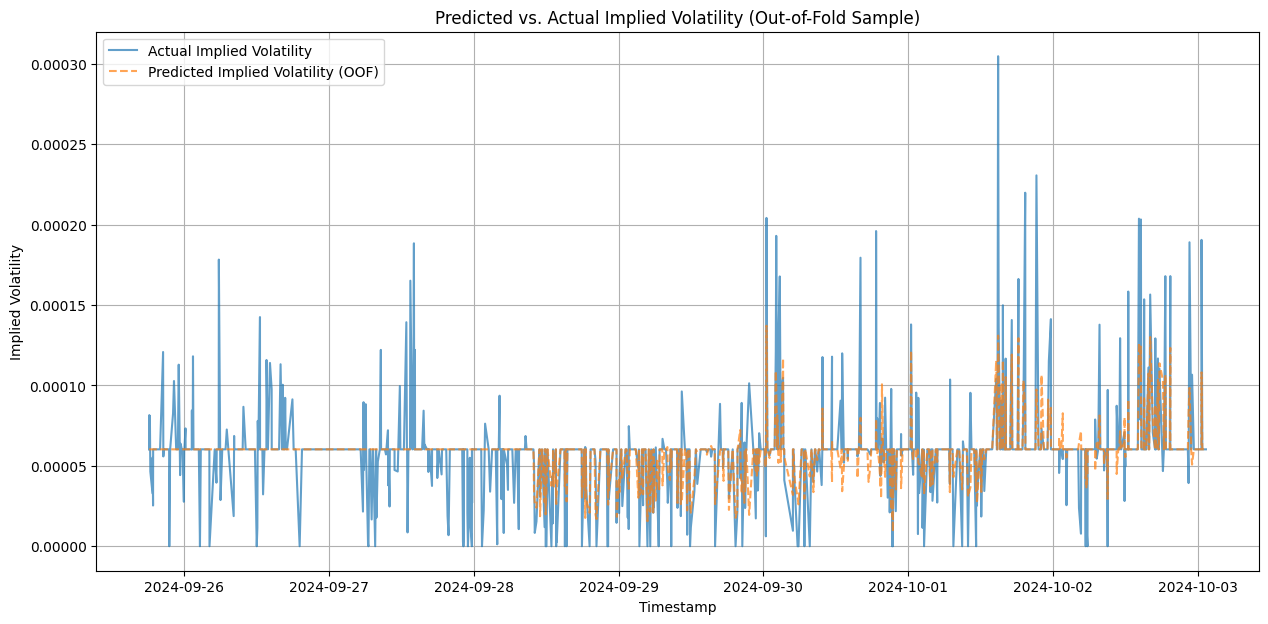

In [16]:

    # --- 5. Prediction on Test Set ---
    print("\nGenerating predictions on the test set...")
    test_df = load_and_prepare_data_csv(test_files, data_type='test')
    
    if not test_df.empty:
        test_df['asset_cat'] = test_df['asset'].astype('category').cat.codes
        test_X = test_df[features]
        
        test_preds = final_model.predict(test_X)
        
        final_submission = pd.DataFrame({'timestamp': test_df.index, 'predicted': test_preds})

        # --- 6. Create Submission File ---
        final_submission.sort_values('timestamp', inplace=True)
        
        if os.path.exists('submission.csv'):
            sample_submission = pd.read_csv('submission.csv')
            if not pd.api.types.is_datetime64_any_dtype(sample_submission['timestamp']):
                 sample_submission['timestamp'] = pd.to_datetime(sample_submission['timestamp'])
            
            final_submission = sample_submission[['timestamp']].merge(final_submission, on='timestamp', how='left')
            final_submission['predicted'].fillna(final_submission['predicted'].mean(), inplace=True)
        else:
            print("Warning: 'submission.csv' not found. Creating submission from predictions only.")

        final_submission.rename(columns={'predicted': 'labels'}, inplace=True)
        final_submission.to_csv('submission.csv', index=False)
        print("\nSubmission file created successfully!")
        print(final_submission.head())
        
        # --- 7. Plotting Predicted vs. Actual for a sample of OOF predictions ---
        print("\nPlotting a sample of Out-of-Fold predictions vs Actual values...")
        
        plt.figure(figsize=(15, 7))
        sample_indices = np.random.choice(oof_indices, size=min(1000, len(oof_indices)), replace=False)
        sample_indices.sort()
        
        plot_df = pd.DataFrame({
            'Actual': y.iloc[sample_indices],
            'Predicted': oof_preds[sample_indices]
        }, index=y.index[sample_indices]).sort_index()

        plt.plot(plot_df.index, plot_df['Actual'], label='Actual Implied Volatility', alpha=0.7)
        plt.plot(plot_df.index, plot_df['Predicted'], label='Predicted Implied Volatility (OOF)', linestyle='--', alpha=0.7)
        
        plt.title('Predicted vs. Actual Implied Volatility (Out-of-Fold Sample)')
        plt.xlabel('Timestamp')
        plt.ylabel('Implied Volatility')
        plt.legend()
        plt.grid(True)
        plt.show()

    else:
        print("\nNo test data found. Submission file not created.")
